# Environment settings

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import tensorflow as tf
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plot
import cv2 as cv
import pandas as pd
from protein_utils import TrainingHelper
from sklearn.metrics import f1_score
import tensorflow.keras.backend as K

In [2]:
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'
NUM_OF_CLASSES = 28
mean_image = 0.052637916
std_image = 0.11212671
OPTIMIZERS = {
    "Adam" : tf.train.AdamOptimizer,
    "SGD" : tf.train.GradientDescentOptimizer,
    "RMS" : tf.train.RMSPropOptimizer
}

In [3]:
# Set tf basic settings
print(tf.__version__)
tf.logging.set_verbosity(tf.logging.INFO)
tf.enable_eager_execution()

1.10.0


# Dataset manipulation and handling

#### Feature encoding for creating tfrecords 

In [4]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

#### Function for loading an image from a given file name

In [5]:
def load_image_specific_filter(file):
    img = cv.imread(file)
    img = img.astype(np.float32)
    return img[:,:,0]

## Creation of 2 tfrecords files, 1 for training set and 1 for validation set
This should only be used once as the tfrecords created are what will be used later on during test time

In [6]:
train_labels = pd.read_csv(TRAIN_PATH + "train.csv")

In [7]:
train_filename = 'data/tfrec/train.tfrecords_full'
writer = tf.python_io.TFRecordWriter(train_filename)
num_of_examples = train_labels.count()['Id']
num_train_set = int(num_of_examples * 0.8)
num_validation_set = num_of_examples - num_train_set
entire_train_ds = np.zeros((1, 512, 512), dtype=np.float32)

for i in range(0, int(num_train_set)):                        
    # Create image and labels
    if (i % 1000 == 0):
        print("Reached image {} out of {}".format(i, num_train_set))
    file_name = (TRAIN_PATH + train_labels['Id'][i] + '_green.png')
    img = load_image_specific_filter(file_name)
    labels = np.zeros(shape=(NUM_OF_CLASSES), dtype=int)
    train_label = [int(s) for s in train_labels['Target'][i].split(' ')]
    labels[train_label] = 1
    
    # Create a feature
    feature = {'train/label': _int64_feature(labels),
               'train/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
    # We will save all of the dataset info to create a mean and std to be used during the preprocessing
    if (i < 1500):
        img = np.expand_dims(img, axis=0)
        entire_train_ds = np.append(entire_train_ds, img, axis=0)
    
    
writer.close()   
mean_image = np.mean(entire_train_ds)
std_image = np.std(entire_train_ds)
del(entire_train_ds)

Reached image 0 out of 24857


AttributeError: 'NoneType' object has no attribute 'astype'

In [9]:
test_filename = 'data/tfrec/train.tfrecords_test'
writer = tf.python_io.TFRecordWriter(test_filename)
num_validation_set = num_of_examples - num_train_set

for i in range(int(num_train_set), num_of_examples):                        
    # Create image and labels
    if (i % 1000 == 0):
        print("Reached image {} out of {}".format(i, num_of_examples))
    file_name = (TRAIN_PATH + train_labels['Id'][i] + '_green.png')
    img = load_image_specific_filter(file_name)
    labels = np.zeros(shape=(NUM_OF_CLASSES), dtype=int)
    train_label = [int(s) for s in train_labels['Target'][i].split(' ')]
    labels[train_label] = 1
    
    # Create a feature
    feature = {'test/label': _int64_feature(labels),
               'test/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
    
writer.close()   

Reached image 25000 out of 31072
Reached image 26000 out of 31072
Reached image 27000 out of 31072
Reached image 28000 out of 31072
Reached image 29000 out of 31072
Reached image 30000 out of 31072
Reached image 31000 out of 31072


#### Function for extracting features from tfrecords

In [6]:
def extract_fn_train(data_record):
    features = {
        # Extract features using the keys set during creation
        'train/label': tf.FixedLenFeature((28), tf.int64),
        'train/image': tf.FixedLenFeature([], tf.string)
    }    
    
    sample = tf.parse_single_example(data_record, features)
    sample['train/image'] = tf.decode_raw(sample['train/image'], tf.float32)
    sample['train/image'] = tf.reshape(sample['train/image'], (512,512))
    sample['train/image'] = sample['train/image']/256
    sample['train/image'] = (sample['train/image'] - mean_image)/std_image
    
    return sample

def extract_fn_test(data_record):
    features = {
        # Extract features using the keys set during creation
        'test/label': tf.FixedLenFeature((28), tf.int64),
        'test/image': tf.FixedLenFeature([], tf.string)
    }    
    
    sample = tf.parse_single_example(data_record, features)
    sample['test/image'] = tf.decode_raw(sample['test/image'], tf.float32)
    sample['test/image'] = tf.reshape(sample['test/image'], (512,512))
    sample['test/image'] = sample['test/image']/256
    sample['test/image'] = (sample['test/image'] - mean_image)/std_image

    return sample

def extract_fn_submission(data_record):
    features = {
        'submission/image': tf.FixedLenFeature([], tf.string)
    }    
    
    sample = tf.parse_single_example(data_record, features)
    sample['submission/image'] = tf.decode_raw(sample['submission/image'], tf.float32)
    sample['submission/image'] = tf.reshape(sample['submission/image'], (512,512))
    sample['submission/image'] = sample['submission/image']/256
    sample['submission/image'] = (sample['submission/image'] - mean_image)/std_image
    
    return sample

## Creating 3 dataset objects, training, validation and test

In [7]:
num_epochs_test = 1
batch_size_test = 70
submission_dataset = tf.data.TFRecordDataset(['data/tfrec/test.tfrecords'])
submission_dataset = submission_dataset.map(extract_fn_submission)
submission_dataset = submission_dataset.batch(batch_size_test)

num_epochs_val = 1
batch_size_val = 70
test_dataset = tf.data.TFRecordDataset(['data/tfrec/train.tfrecords_test'])
test_dataset = test_dataset.map(extract_fn_test)
test_dataset = test_dataset.batch(batch_size_val)

num_epochs = 100
batch_size = 50
buffer_size = 1000

train_dataset = tf.data.TFRecordDataset(['data/tfrec/train.tfrecords_full'])
train_dataset = train_dataset.map(extract_fn_train)
train_dataset = train_dataset.apply(tf.contrib.data.shuffle_and_repeat(buffer_size, num_epochs))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.apply(tf.contrib.data.prefetch_to_device("/device:GPU:0"))

# Model Creation

In [8]:
class ProteinClassifier(tf.keras.Model):
    def __init__(self, optimizer1="Adam", optimizer2="Adam", lr1=1e-3, lr2=1e-5):
        super().__init__()
        
        self.threshold = 0.5
        
        # Block1
        self.block1_conv1 = tf.keras.layers.Conv2D(filters=16,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                activation=tf.nn.relu,
                                                use_bias=True,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block1_conv2 = tf.keras.layers.Conv2D(filters=16,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                activation=tf.nn.relu,
                                                use_bias=True,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block1_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Block2
        self.block2_conv1 = tf.keras.layers.Conv2D(filters=16,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                activation=tf.nn.relu,
                                                use_bias=True,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block2_conv2 = tf.keras.layers.Conv2D(filters=16,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                activation=tf.nn.relu,
                                                use_bias=True,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block2_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Block3
        self.block3_conv1 = tf.keras.layers.Conv2D(filters=24,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                activation=tf.nn.relu,
                                                use_bias=True,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block3_conv2 = tf.keras.layers.Conv2D(filters=24,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                activation=tf.nn.leaky_relu,
                                                use_bias=True,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block3_conv3 = tf.keras.layers.Conv2D(filters=24,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                activation=tf.nn.relu,
                                                use_bias=True,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block3_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Block4
        self.block4_conv1 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                activation=tf.nn.relu,
                                                use_bias=True,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block4_conv2 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                activation=tf.nn.relu,
                                                use_bias=True,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block4_conv3 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                activation=tf.nn.relu,
                                                use_bias=True,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block4_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Block4
        self.block5_conv1 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                activation=tf.nn.relu,
                                                use_bias=True,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block5_conv2 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                activation=tf.nn.relu,
                                                use_bias=True,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block5_conv3 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                activation=tf.nn.relu,
                                                use_bias=True,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block5_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        
        
        # Dense output layer
        self.fc1 = tf.keras.layers.Dense(4096, activation=tf.nn.relu)
        
        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(rate=0.3)
        
        # Dense layer for classes
        self.fc2 = tf.keras.layers.Dense(28)
        
        # Optimizers
        self.cross_entropy_optimizer = OPTIMIZERS[optimizer1](learning_rate=lr1)
        self.f1_optimizer = OPTIMIZERS[optimizer2](learning_rate=lr2)
        
        
    def call(self, inputs, training=True, dropout=False, **kwargs):
        
        # Input Layer
        input_layer = tf.reshape(inputs, [-1, 512, 512, 1])
        
        # Block1
        x_1 = self.block1_conv1(input_layer)
        x_1 = self.block1_conv2(x_1)
        x_1 = self.block1_pool(x_1)
        
        # Block2
        x_2 = self.block2_conv1(x_1)
        x_2 = self.block2_conv2(x_2)
        x_2 = self.block2_pool(x_2)
        
        # Block3
        x_3 = self.block3_conv1(x_2)
        x_3 = self.block3_conv2(x_3)
        x_3 = self.block3_conv3(x_3)
        x_3 = self.block3_pool(x_3)
        
        # Block4
        x_4 = self.block4_conv1(x_3)
        x_4 = self.block4_conv2(x_4)
        x_4 = self.block4_conv3(x_4)
        x_4 = self.block4_pool(x_4)
        
        # Block3
        x_5 = self.block5_conv1(x_4)
        x_5 = self.block5_conv2(x_5)
        x_5 = self.block5_conv3(x_5)
        x_5 = self.block3_pool(x_5)       
        x_5 = tf.reshape(x_5, [x_5.shape[0], -1])
        
        x_fc_1 = self.fc1(x_5)
        
        if (dropout):
            x_fc_1 = self.dropout(x_fc_1)
            
        logits = self.fc2(x_fc_1)
        
        return logits 
    
    def f1_loss(self, preds, labels):
        
        f1_scores = self.calc_f1_scores(labels, preds)
        f1_loss = 1 - f1_scores
        
        return f1_loss
    
    def cross_entropy_loss(self, labels, logits):        
        labels_cast = tf.cast(labels, tf.float32)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_cast, logits=logits)
        cross_entropy_loss = tf.reduce_mean(loss)
        
        return cross_entropy_loss
    
    def optimize(self, inputs, labels, training=True, dropout=False, loss_type="Cross Entropy"):
        with tf.GradientTape(persistent=False) as tape:
            predictions, logits = self.perdict_protein(inputs, dropout)

            if loss_type == "Cross Entropy":
                loss = self.cross_entropy_loss(labels, logits)
            else:
                loss = self.f1_loss(predictions, labels)
        
            if  training:       
                if loss_type == "Cross Entropy":
                    gradients = tape.gradient(loss, self.variables)
                    self.cross_entropy_optimizer.apply_gradients(zip(gradients, self.variables))
                else:
                    gradients = tape.gradient(loss, self.variables[26:30])
                    self.f1_optimizer.apply_gradients(zip(gradients, self.variables[26:30]))
        del(tape)
        return tf.reduce_mean(loss)
    
    def test(self, inputs, labels):
        predictions, _ = self.perdict_protein(inputs)
        predictions = tf.round(predictions)
        f1_scores = self.calc_f1_scores(labels, predictions)
        
        return f1_scores

    def calc_f1_scores(self, labels, predictions):
        
        labels_cast = tf.cast(labels, tf.float32)
        
        relevant_labels = np.where(K.sum(labels_cast, axis=0))
        relevant_predictions = np.where(K.sum(predictions, axis=0))
        relevant_classes = list(set(relevant_labels[0].tolist() + relevant_predictions[0].tolist()))
        
        tp = K.sum(K.cast(labels_cast*predictions, 'float'), axis=0)
        tn = K.sum(K.cast((1-labels_cast)*(1-predictions), 'float'), axis=0)
        fp = K.sum(K.cast((1-labels_cast)*predictions, 'float'), axis=0)
        fn = K.sum(K.cast(labels_cast*(1-predictions), 'float'), axis=0)

        p = tp / (tp + fp + K.epsilon())
        r = tp / (tp + fn + K.epsilon())

        f1 = 2*p*r / (p+r+K.epsilon())
        f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
        f1 = tf.gather(f1, relevant_classes)
        f1 = tf.reduce_mean(f1)
        return f1

    def get_best_thresh(self, predictions, labels, save_threshold=False, step_size=0.005):
        thresholds = np.arange(0, 1, step_size)
        best_f1_score = 0
        best_thresh = 0
        for th in thresholds:
            under = np.where(np.array(predictions) < th)
            over = np.where(np.array(predictions) >= th)
            preds = np.array(predictions)
            preds[under] = 0
            preds[over] = 1
            prediction = tf.convert_to_tensor(preds, dtype=tf.float32)
            curr_f1_score = f1_score(labels, prediction, average='macro')
            if (curr_f1_score > best_f1_score):
                best_f1_score = curr_f1_score
                best_thresh = th
                
        if (save_threshold):
            self.threshold = best_thresh
        
        
        return best_thresh, best_f1_score
        
    
    def predict(self, inputs):
        logits = self(inputs)
        #prediction = tf.round(tf.nn.sigmoid(logits))
        return tf.nn.sigmoid(logits)
    
    def perdict_protein(self, inputs, dropout=False):
        logits = self(inputs)
        predictions = tf.nn.sigmoid(logits)
        return predictions, logits
        #return tf.round(predictions)

# Train a small batch to overfit
Need to make sure that we can reach an accuracy of ~100% on a small dataset.

In addition we will set basic hyperparameters of optimizer and learning rate.

### Create a small dataset

In [9]:
X_b = tf.zeros((1,512,512), tf.float32)
Y_b = tf.zeros((1,28), tf.float32)
count = 0
itr = train_dataset.make_one_shot_iterator()
for step, x in enumerate(itr):
    X_b = np.append(X_b, x['train/image'], axis=0)
    Y_b = np.append(Y_b, x['train/label'], axis=0)
    count += 1
    if count == 16:
        break
        
X_b = X_b[1:,:,:]
Y_b = Y_b[1:,:]        

### Train small dataset with different optimizers and learning rates

In [10]:
#optimizers = ["Adam", "RMS"]
#lrs = [1e-5, 5*1e-6, 1e-6, 5*1e-7]
optimizers = ["Adam"]
lrs = [1e-3]
model_helpers = []
for optimizer in optimizers:
    for lr in lrs:
        model_helper = TrainingHelper(step_size=40, y_value_names=["training loss", "training F1 score"])
        with tf.device("/device:GPU:0"):
            try:
                model = ProteinClassifier(optimizer1=optimizer, lr1=lr)
                for step in range(1000):
                    part = step % 16
                    loss = model.optimize(X_b[part*50:part*50+50,:,:], Y_b[part*50:part*50+50,:],loss_type="Cross Entropy").numpy()
                    score =  model.test(X_b[part*50:part*50+50,:,:], Y_b[part*50:part*50+50,:])
                    model_helper.append_outputs_if_required({"training loss" : loss, "training F1 score" : score},
                                                            curr_step=step, print_output=True)
                model_helpers.append(model_helper)
                    
            except Exception as err:
                raise
            finally:
                pass

[01.11|13:42:19] Step 0: training loss: 0.693159
[01.11|13:42:19] Step 0: training F1 score: 0.000000
[01.11|13:43:21] Step 40: training loss: 0.164379
[01.11|13:43:21] Step 40: training F1 score: 0.000000
[01.11|13:44:22] Step 80: training loss: 0.166749
[01.11|13:44:22] Step 80: training F1 score: 0.000000
[01.11|13:45:24] Step 120: training loss: 0.158459
[01.11|13:45:24] Step 120: training F1 score: 0.026738
[01.11|13:46:25] Step 160: training loss: 0.136663
[01.11|13:46:25] Step 160: training F1 score: 0.116162
[01.11|13:47:27] Step 200: training loss: 0.068776
[01.11|13:47:27] Step 200: training F1 score: 0.841158
[01.11|13:48:29] Step 240: training loss: 0.053027
[01.11|13:48:29] Step 240: training F1 score: 0.787663
[01.11|13:49:30] Step 280: training loss: 0.006698
[01.11|13:49:30] Step 280: training F1 score: 1.000000
[01.11|13:50:32] Step 320: training loss: 0.016463
[01.11|13:50:32] Step 320: training F1 score: 0.996257
[01.11|13:51:33] Step 360: training loss: 0.007869
[01

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

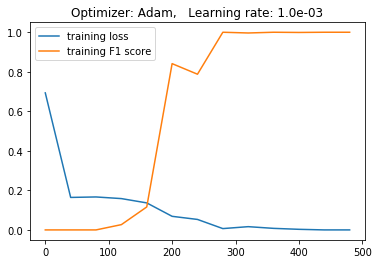

In [11]:
model_helper.show_graph(title="Optimizer: %s,   Learning rate: %.1e" % ("Adam", 1e-3),
                     keys_to_print=["training loss", "training F1 score"])

In [12]:
model.save_weights('cpt/cpt_mini')

In [82]:
model = ProteinClassifier()
model.load_weights('cpt/cpt_mini')
#score =  model.test(X_b[2:3,:,:], Y_b[2:3,:])
#print(score)
for i in range(50):
    score =  model.test(X_b[i:i+1,:,:], Y_b[i:i+1,:])
    print(score)

tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dtype=float32)
tf.Tensor(0.9999998, shape=(), dty

In [19]:
model_helper = TrainingHelper(step_size=40, y_value_names=["training loss", "training F1 score"])
with tf.device("/device:GPU:0"):
    try:
        model = ProteinClassifier(lr2=2*1e-3, optimizer2="Adam")
        model.load_weights('cpt/cpt_mini')
        for step in range(480):
            part = step % 16
            loss = model.optimize(X_b[part*50:part*50+50,:,:], Y_b[part*50:part*50+50,:],loss_type="f1").numpy()
            score =  model.test(X_b[part*50:part*50+50,:,:], Y_b[part*50:part*50+50,:])
            model_helper.append_outputs_if_required({"training loss" : loss, "training F1 score" : score},
                                                    curr_step=step, print_output=True)

    except Exception as err:
        raise
    finally:
        pass

[01.11|15:04:48] Step 0: training loss: 0.285842
[01.11|15:04:48] Step 0: training F1 score: 1.000000
[01.11|15:05:50] Step 40: training loss: 0.415352
[01.11|15:05:50] Step 40: training F1 score: 0.980392
[01.11|15:06:52] Step 80: training loss: 0.296443
[01.11|15:06:52] Step 80: training F1 score: 1.000000
[01.11|15:07:54] Step 120: training loss: 0.465225
[01.11|15:07:54] Step 120: training F1 score: 0.905271
[01.11|15:08:56] Step 160: training loss: 0.293047
[01.11|15:08:56] Step 160: training F1 score: 0.995454
[01.11|15:09:58] Step 200: training loss: 0.463647
[01.11|15:09:58] Step 200: training F1 score: 0.933396
[01.11|15:11:00] Step 240: training loss: 0.293805
[01.11|15:11:00] Step 240: training F1 score: 0.998889
[01.11|15:12:02] Step 280: training loss: 0.425255
[01.11|15:12:02] Step 280: training F1 score: 0.896164


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

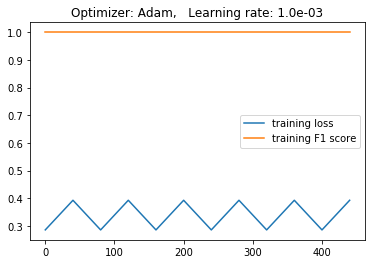

In [16]:
model_helper.show_graph(title="Optimizer: %s,   Learning rate: %.1e" % ("Adam", 1e-3),
                     keys_to_print=["training loss", "training F1 score"])

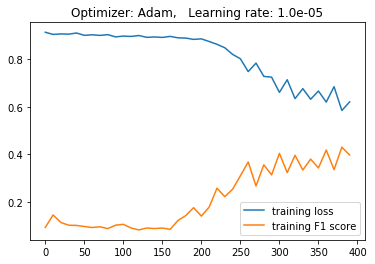

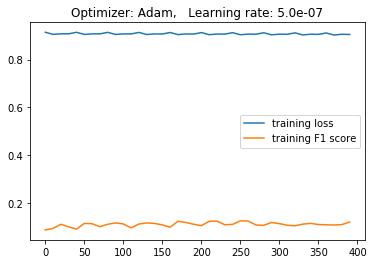

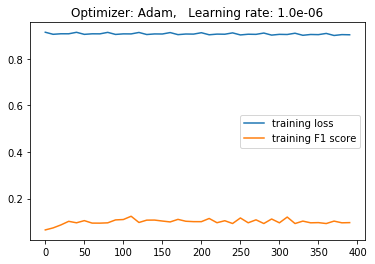

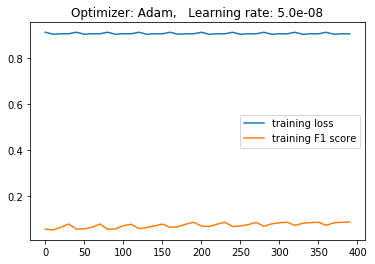

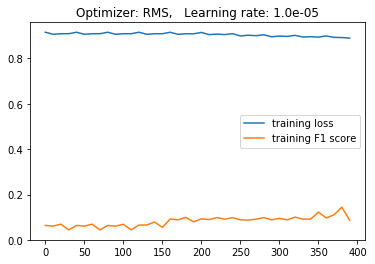

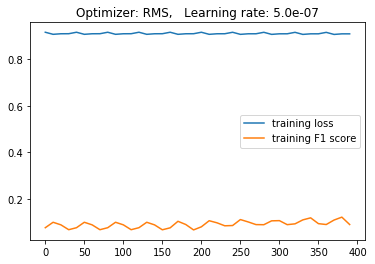

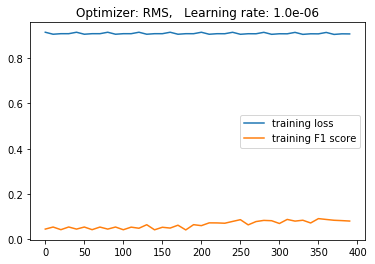

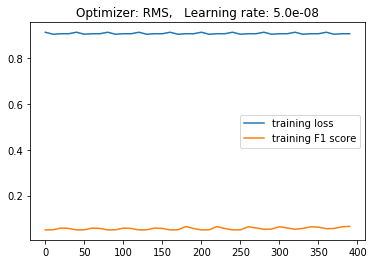

In [16]:
for num, model in enumerate(model_helpers):
    model.show_graph(title="Optimizer: %s,   Learning rate: %.1e" % (optimizers[int(num/len(lrs))], lrs[int(num%len(lrs))]),
                     keys_to_print=["training loss", "training F1 score"])

# Model training with entire dataset- initial train, using dropout
We will start by training the model on the entire dataset to get a set of variables.

We will then save the weights at the point where the validation score is highest (before overfitting).

In [ ]:
with tf.device("/device:GPU:0"):
    try:
        best_score = 0
        model = ProteinClassifier(lr1=1e-3)
        model_helper = TrainingHelper(step_size=20, 
                        y_value_names=["training loss", "training F1 score", "validation score"])
        itr = train_dataset.make_one_shot_iterator()
        for step, x in enumerate(itr):
            loss = model.optimize(x['train/image'], x['train/label'], dropout=True).numpy()
            model_helper.append_outputs_if_required({"training loss" : loss},
                                                            curr_step=step, print_output=False)
            if (step % 200 == 0):
                predictions = None
                labels = None
                val_itr = test_dataset.make_one_shot_iterator()
                for val_step, val_x in enumerate(val_itr):
                    curr_prediction, _ = model.perdict_protein(val_x['test/image'])
                    curr_prediction = tf.round(curr_prediction)
                    if predictions is not None:
                        predictions = np.concatenate((predictions, curr_prediction), axis=0)
                        labels = np.concatenate((labels, val_x['test/label'].numpy()))
                    else:
                        predictions = curr_prediction
                        labels = val_x['test/label'].numpy()
                val_score = model.calc_f1_scores(labels, predictions)
                
                train_score = model.test(x['train/image'], x['train/label'])
                model_helper.append_outputs_if_required({"training loss" : loss, "training F1 score" : train_score,
                                                         "validation score" : val_score}, curr_step=step, print_output=True)
            if (step % 50 == 0):
                if (val_score > best_score):
                    best_score = val_score
                    model.save_weights('cpt/cpt.weights')
                    
    except Exception as err:
        raise
    finally:
        pass
        

[01.11|15:15:23] Step 0: training loss: 0.693478
[01.11|15:15:23] Step 0: training F1 score: 0.000000
[01.11|15:15:23] Step 0: validation score: 0.000000
[01.11|15:20:46] Step 200: training loss: 0.162556
[01.11|15:20:46] Step 200: training F1 score: 0.015686
[01.11|15:20:46] Step 200: validation score: 0.006536
[01.11|15:25:35] Step 400: training loss: 0.160384
[01.11|15:25:35] Step 400: training F1 score: 0.015000
[01.11|15:25:35] Step 400: validation score: 0.016403
[01.11|15:30:24] Step 600: training loss: 0.160070
[01.11|15:30:24] Step 600: training F1 score: 0.067460
[01.11|15:30:24] Step 600: validation score: 0.034765
[01.11|15:35:13] Step 800: training loss: 0.162079
[01.11|15:35:13] Step 800: training F1 score: 0.072531
[01.11|15:35:13] Step 800: validation score: 0.042787
[01.11|15:54:19] Step 1600: training loss: 0.128740
[01.11|15:54:19] Step 1600: training F1 score: 0.084072
[01.11|15:54:19] Step 1600: validation score: 0.068560
[01.11|15:59:07] Step 1800: training loss: 

In [ ]:
model_helper.show_graph(keys_to_print=["training loss", "training F1 score", "validation score"])

## 2nd phase training, working on last layers and improving f1 score loss directly

In [10]:
with tf.device("/device:GPU:0"):
    try:
        best_score = 0
        model = ProteinClassifier(lr2=1e-3)
        model.load_weights('cpt/cpt.weights')
        model_helper = TrainingHelper(step_size=50, 
                        y_value_names=["training loss", "training F1 score", "validation score"])
        itr = train_dataset.make_one_shot_iterator()
        for step, x in enumerate(itr):
            x_label_cast = tf.cast(x['train/label'], tf.float32)
            loss = model.optimize(x['train/image'], x_label_cast, loss_type="f1").numpy()
            model_helper.append_outputs_if_required({"training loss" : loss},
                                                            curr_step=step, print_output=False)
            if (step % 100 == 0):
                predictions = None
                labels = None
                val_itr = test_dataset.make_one_shot_iterator()
                for val_step, val_x in enumerate(val_itr):
                    curr_prediction, _ = model.perdict_protein(val_x['test/image'])
                    curr_prediction = tf.round(curr_prediction)
                    if predictions is not None:
                        predictions = np.concatenate((predictions, curr_prediction), axis=0)
                        labels = np.concatenate((labels, val_x['test/label'].numpy()))
                    else:
                        predictions = curr_prediction
                        labels = val_x['test/label'].numpy()
                val_score = f1_score(labels, predictions, average='macro')
                
                train_score = model.test(x['train/image'], x['train/label'])
                model_helper.append_outputs_if_required({"training loss" : loss, "training F1 score" : train_score,
                                                         "validation score" : val_score}, curr_step=step, print_output=True)
            if (step % 50 == 0):
                if (val_score > best_score):
                    best_score = val_score
                    model.save_weights('cpt/cpt_w_f1.weights')
                    
    except Exception as err:
        raise
    finally:
        pass
        

[30.10|20:17:26] Step 0: training loss: 0.769931
[30.10|20:17:26] Step 0: training F1 score: 0.338719
[30.10|20:17:26] Step 0: validation score: 0.213432
[30.10|20:19:48] Step 100: training loss: 0.592861
[30.10|20:19:48] Step 100: training F1 score: 0.467138
[30.10|20:19:48] Step 100: validation score: 0.255404
[30.10|20:22:10] Step 200: training loss: 0.645528
[30.10|20:22:10] Step 200: training F1 score: 0.394054
[30.10|20:22:10] Step 200: validation score: 0.255586
[30.10|20:24:46] Step 300: training loss: 0.549136
[30.10|20:24:46] Step 300: training F1 score: 0.530697
[30.10|20:24:46] Step 300: validation score: 0.251697
[30.10|20:28:25] Step 400: training loss: 0.660273
[30.10|20:28:25] Step 400: training F1 score: 0.440571
[30.10|20:28:25] Step 400: validation score: 0.268411
[30.10|20:32:50] Step 500: training loss: 0.501307
[30.10|20:32:50] Step 500: training F1 score: 0.554812
[30.10|20:32:50] Step 500: validation score: 0.265190
[30.10|20:36:32] Step 600: training loss: 0.65

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

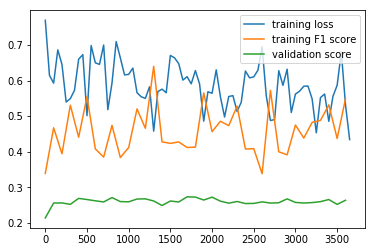

In [11]:
model_helper.show_graph(keys_to_print=["training loss", "training F1 score", "validation score"])

In [12]:
with tf.device("/device:GPU:0"):
    try:
        best_score = 0
        model = ProteinClassifier(lr2=1e-5)
        model.load_weights('cpt/cpt.weights')
        model_helper = TrainingHelper(step_size=50, 
                        y_value_names=["training loss", "training F1 score", "validation score"])
        itr = train_dataset.make_one_shot_iterator()
        for step, x in enumerate(itr):
            x_label_cast = tf.cast(x['train/label'], tf.float32)
            loss = model.optimize(x['train/image'], x_label_cast, loss_type="f1").numpy()
            model_helper.append_outputs_if_required({"training loss" : loss},
                                                            curr_step=step, print_output=False)
            if (step % 100 == 0):
                predictions = None
                labels = None
                val_itr = test_dataset.make_one_shot_iterator()
                for val_step, val_x in enumerate(val_itr):
                    curr_prediction, _ = model.perdict_protein(val_x['test/image'])
                    curr_prediction = tf.round(curr_prediction)
                    if predictions is not None:
                        predictions = np.concatenate((predictions, curr_prediction), axis=0)
                        labels = np.concatenate((labels, val_x['test/label'].numpy()))
                    else:
                        predictions = curr_prediction
                        labels = val_x['test/label'].numpy()
                val_score = f1_score(labels, predictions, average='macro')
                
                train_score = model.test(x['train/image'], x['train/label'])
                model_helper.append_outputs_if_required({"training loss" : loss, "training F1 score" : train_score,
                                                         "validation score" : val_score}, curr_step=step, print_output=True)
            if (step % 50 == 0):
                if (val_score > best_score):
                    best_score = val_score
                    model.save_weights('cpt/cpt_w_f1.weights')
                    
    except Exception as err:
        raise
    finally:
        pass
        

[31.10|06:02:11] Step 0: training loss: 0.673070
[31.10|06:02:11] Step 0: training F1 score: 0.336661
[31.10|06:02:11] Step 0: validation score: 0.212222
[31.10|06:04:33] Step 100: training loss: 0.667369
[31.10|06:04:33] Step 100: training F1 score: 0.350658
[31.10|06:04:33] Step 100: validation score: 0.215006
[31.10|06:06:55] Step 200: training loss: 0.686979
[31.10|06:06:55] Step 200: training F1 score: 0.320046
[31.10|06:06:55] Step 200: validation score: 0.219856
[31.10|06:09:17] Step 300: training loss: 0.731423
[31.10|06:09:17] Step 300: training F1 score: 0.298824
[31.10|06:09:17] Step 300: validation score: 0.222638
[31.10|06:11:39] Step 400: training loss: 0.597775
[31.10|06:11:39] Step 400: training F1 score: 0.460969
[31.10|06:11:39] Step 400: validation score: 0.225843
[31.10|06:14:01] Step 500: training loss: 0.700427
[31.10|06:14:01] Step 500: training F1 score: 0.328424
[31.10|06:14:01] Step 500: validation score: 0.228374
[31.10|06:16:22] Step 600: training loss: 0.73

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

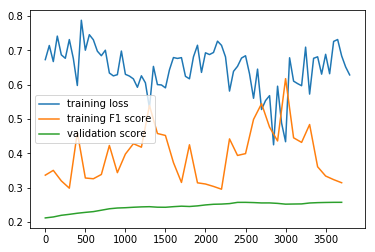

In [13]:
model_helper.show_graph(keys_to_print=["training loss", "training F1 score", "validation score"])

# Get best threshold using validation set

In [11]:
val_model = ProteinClassifier()
val_model.load_weights('cpt/cpt_w_f1.weights')
predictions = None
labels = None
with tf.device("/device:GPU:0"):
    val_itr = test_dataset.make_one_shot_iterator()
    for val_step, val_x in enumerate(val_itr):
        curr_prediction = val_model.predict(val_x['test/image']).numpy()
        if predictions is not None:
            predictions = np.concatenate((predictions, curr_prediction), axis=0)
            labels = np.concatenate((labels, val_x['test/label'].numpy()))
        else:
            predictions = curr_prediction
            labels = val_x['test/label'].numpy()

    
    print(val_model.get_best_thresh(predictions, labels, save_threshold=True))

(0.39, 0.27807526499805435)


In [10]:
val_model.threshold

0.035

# Prediction on validation set

In [208]:
val_model = ProteinClassifier()
val_model.load_weights('cpt/cpt.weights')
val_model.threshold = 0.23
predictions = None
with tf.device("/device:GPU:0"):
    val_itr = test_dataset.make_one_shot_iterator()
    for val_step, val_x in enumerate(val_itr):
        curr_prediction = val_model.perdict_protein(val_x['test/image'])
        if predictions is not None:
            predictions = np.concatenate((predictions, curr_prediction), axis=0)
            labels = np.concatenate((labels, val_x['test/label'].numpy()))
        else:
            predictions = curr_prediction
            labels = val_x['test/label'].numpy()
f1_scores = f1_score(labels, predictions, average='macro')
print(f1_scores)



(<tf.Tensor: id=5380688, shape=(), dtype=float32, numpy=0.43911824>, <tf.Tensor: id=5380707, shape=(), dtype=float32, numpy=0.43911824>)


In [122]:
submission = pd.read_csv("sample_submission.csv")

In [123]:
submission_copy = submission.copy()
for index, line in enumerate(protein_prediction):
    proteins = np.where(line == 1)[0]
    guess = " ".join(str(x) for x in proteins)
    submission_copy['Predicted'][index] = guess

submission_copy.to_csv("submission_1.csv", index=False)

/home/michaelfi/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Prediction on test set

In [161]:
test_model = ProteinClassifier()
test_model.load_weights('cpt/cpt.weights')
test_model.threshold = 0.23
protein_prediction = None
with tf.device("/device:GPU:0"):
    val_itr = submission_dataset.make_one_shot_iterator()
    for val_step, val_x in enumerate(val_itr):
        curr_prediction = test_model.perdict_protein(val_x['submission/image'])
        if protein_prediction is not None:
            protein_prediction = np.concatenate((protein_prediction, curr_prediction), axis=0)
        else:
            protein_prediction = curr_prediction

In [204]:
print(protein_prediction)

None


In [162]:
submission = pd.read_csv("sample_submission.csv")

In [188]:
submission_copy = submission.copy()
for index, line in enumerate(protein_prediction):
    proteins = np.where(line == 1)[0].tolist()
    guess = " ".join(str(x) for x in proteins[::-1])
    submission_copy['Predicted'][index] = guess

submission_copy.to_csv("submission_1.csv", index=False)

/home/michaelfi/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [189]:
submission_copy.head


<bound method NDFrame.head of                                          Id    Predicted
0      00008af0-bad0-11e8-b2b8-ac1f6b6435d0            2
1      0000a892-bacf-11e8-b2b8-ac1f6b6435d0           23
2      0006faa6-bac7-11e8-b2b7-ac1f6b6435d0      25 21 0
3      0008baca-bad7-11e8-b2b9-ac1f6b6435d0            0
4      000cce7e-bad4-11e8-b2b8-ac1f6b6435d0           11
5      00109f6a-bac8-11e8-b2b7-ac1f6b6435d0            2
6      001765de-bacd-11e8-b2b8-ac1f6b6435d0         25 0
7      0018641a-bac9-11e8-b2b8-ac1f6b6435d0         25 0
8      00200f22-bad7-11e8-b2b9-ac1f6b6435d0            0
9      0026f154-bac6-11e8-b2b7-ac1f6b6435d0        25 21
10     002729d2-bace-11e8-b2b8-ac1f6b6435d0           23
11     002c1a7c-bad4-11e8-b2b8-ac1f6b6435d0            5
12     003170fa-bacd-11e8-b2b8-ac1f6b6435d0           25
13     0031820a-baca-11e8-b2b8-ac1f6b6435d0           23
14     00407c16-bad3-11e8-b2b8-ac1f6b6435d0            0
15     005ce2ea-bacc-11e8-b2b8-ac1f6b6435d0           23
1

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]


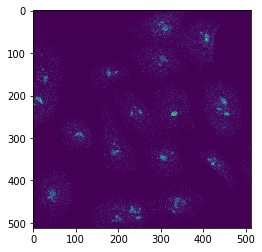

In [186]:
with tf.device("/device:GPU:0"):
    val_itr = submission_dataset.make_one_shot_iterator()
    for val_step, val_x in enumerate(val_itr):
        imshow(val_x['submission/image'][0]*std_image + mean_image)
        print(test_model.perdict_protein(val_x['submission/image'][0]))
        break